In [1]:
import torch
from diffusers import StableDiffusion3Pipeline

/users/gmongaras/miniconda3/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-12-18 09:33:18.627394: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-18 09:33:19.356877: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT



===================================BUG REPORT===================================
Welcome to bitsandbytes. For bug reports, please run

python -m bitsandbytes

 and submit this information together with your error trace to: https://github.com/TimDettmers/bitsandbytes/issues
bin /users/gmongaras/miniconda3/lib/python3.10/site-packages/bitsandbytes/libbitsandbytes_cuda118.so
CUDA SETUP: CUDA runtime path found: /users/gmongaras/cuda-11.8/lib64/libcudart.so
CUDA SETUP: Highest compute capability among GPUs detected: 8.0
CUDA SETUP: Detected CUDA version 118
CUDA SETUP: Loading binary /users/gmongaras/miniconda3/lib/python3.10/site-packages/bitsandbytes/libbitsandbytes_cuda118.so...


/users/gmongaras/miniconda3/lib/python3.10/site-packages/bitsandbytes/cuda_setup/main.py:149: UserWarning: /hpc/mp/apps/conda did not contain ['libcudart.so', 'libcudart.so.11.0', 'libcudart.so.12.0'] as expected! Searching further paths...
  warn(msg)


In [2]:
# Read token from .env file
with open(".env", "r") as f:
    token = f.read().strip()

pipe = StableDiffusion3Pipeline.from_pretrained("stabilityai/stable-diffusion-3-medium-diffusers", torch_dtype=torch.float16, cache_dir="./cache", token=token)
pipe = pipe.to("cuda")

Loading pipeline components...: 100%|██████████| 9/9 [00:02<00:00,  3.21it/s]


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from diffusers.configuration_utils import ConfigMixin, register_to_config
from diffusers.loaders import FromOriginalModelMixin, PeftAdapterMixin
from diffusers.models.attention import FeedForward, JointTransformerBlock
from diffusers.models.attention_processor import (
    Attention,
    AttentionProcessor,
    FusedJointAttnProcessor2_0,
    JointAttnProcessor2_0,
)
from diffusers.models.modeling_utils import ModelMixin
from diffusers.models.normalization import AdaLayerNormContinuous, AdaLayerNormZero
from diffusers.utils import USE_PEFT_BACKEND, is_torch_version, logging, scale_lora_layers, unscale_lora_layers
from diffusers.utils.torch_utils import maybe_allow_in_graph
from diffusers.models.embeddings import CombinedTimestepTextProjEmbeddings, PatchEmbed
from diffusers.models.modeling_outputs import Transformer2DModelOutput

from typing import Optional

import diffusers



@maybe_allow_in_graph
class JointTransformerBlock(nn.Module):
    r"""
    A Transformer block following the MMDiT architecture, introduced in Stable Diffusion 3.

    Reference: https://arxiv.org/abs/2403.03206

    Parameters:
        dim (`int`): The number of channels in the input and output.
        num_attention_heads (`int`): The number of heads to use for multi-head attention.
        attention_head_dim (`int`): The number of channels in each head.
        context_pre_only (`bool`): Boolean to determine if we should add some blocks associated with the
            processing of `context` conditions.
    """

    def __init__(self, dim, num_attention_heads, attention_head_dim, context_pre_only=False):
        super().__init__()

        self.context_pre_only = context_pre_only
        context_norm_type = "ada_norm_continous" if context_pre_only else "ada_norm_zero"

        self.norm1 = AdaLayerNormZero(dim)

        if context_norm_type == "ada_norm_continous":
            self.norm1_context = AdaLayerNormContinuous(
                dim, dim, elementwise_affine=False, eps=1e-6, bias=True, norm_type="layer_norm"
            )
        elif context_norm_type == "ada_norm_zero":
            self.norm1_context = AdaLayerNormZero(dim)
        else:
            raise ValueError(
                f"Unknown context_norm_type: {context_norm_type}, currently only support `ada_norm_continous`, `ada_norm_zero`"
            )
        if hasattr(F, "scaled_dot_product_attention"):
            processor = JointAttnProcessor2_0()
        else:
            raise ValueError(
                "The current PyTorch version does not support the `scaled_dot_product_attention` function."
            )
        self.attn = Attention(
            query_dim=dim,
            cross_attention_dim=None,
            added_kv_proj_dim=dim,
            dim_head=attention_head_dim,
            heads=num_attention_heads,
            out_dim=dim,
            context_pre_only=context_pre_only,
            bias=True,
            processor=processor,
        )

        self.norm2 = nn.LayerNorm(dim, elementwise_affine=False, eps=1e-6)
        self.ff = FeedForward(dim=dim, dim_out=dim, activation_fn="gelu-approximate")

        if not context_pre_only:
            self.norm2_context = nn.LayerNorm(dim, elementwise_affine=False, eps=1e-6)
            self.ff_context = FeedForward(dim=dim, dim_out=dim, activation_fn="gelu-approximate")
        else:
            self.norm2_context = None
            self.ff_context = None

        # let chunk size default to None
        self._chunk_size = None
        self._chunk_dim = 0

    # Copied from diffusers.models.attention.BasicTransformerBlock.set_chunk_feed_forward
    def set_chunk_feed_forward(self, chunk_size: Optional[int], dim: int = 0):
        # Sets chunk feed-forward
        self._chunk_size = chunk_size
        self._chunk_dim = dim

    def forward(
        self, hidden_states: torch.FloatTensor, encoder_hidden_states: torch.FloatTensor, temb: torch.FloatTensor
    ):
        residual = hidden_states.clone()

        norm_hidden_states, gate_msa, shift_mlp, scale_mlp, gate_mlp = self.norm1(hidden_states, emb=temb)

        if self.context_pre_only:
            norm_encoder_hidden_states = self.norm1_context(encoder_hidden_states, temb)
        else:
            norm_encoder_hidden_states, c_gate_msa, c_shift_mlp, c_scale_mlp, c_gate_mlp = self.norm1_context(
                encoder_hidden_states, emb=temb
            )

        # Attention.
        attn_output, context_attn_output = self.attn(
            hidden_states=norm_hidden_states, encoder_hidden_states=norm_encoder_hidden_states
        )

        # Process attention outputs for the `hidden_states`.
        attn_output = gate_msa.unsqueeze(1) * attn_output
        hidden_states = residual + attn_output

        norm_hidden_states = self.norm2(hidden_states)
        norm_hidden_states = norm_hidden_states * (1 + scale_mlp[:, None]) + shift_mlp[:, None]
        if self._chunk_size is not None:
            # "feed_forward_chunk_size" can be used to save memory
            ff_output = _chunked_feed_forward(self.ff, norm_hidden_states, self._chunk_dim, self._chunk_size)
        else:
            ff_output = self.ff(norm_hidden_states)
        ff_output = gate_mlp.unsqueeze(1) * ff_output

        hidden_states = residual + ff_output

        # Process attention outputs for the `encoder_hidden_states`.
        if self.context_pre_only:
            encoder_hidden_states = None
        else:
            context_attn_output = c_gate_msa.unsqueeze(1) * context_attn_output
            encoder_hidden_states = encoder_hidden_states + context_attn_output

            norm_encoder_hidden_states = self.norm2_context(encoder_hidden_states)
            norm_encoder_hidden_states = norm_encoder_hidden_states * (1 + c_scale_mlp[:, None]) + c_shift_mlp[:, None]
            if self._chunk_size is not None:
                # "feed_forward_chunk_size" can be used to save memory
                context_ff_output = _chunked_feed_forward(
                    self.ff_context, norm_encoder_hidden_states, self._chunk_dim, self._chunk_size
                )
            else:
                context_ff_output = self.ff_context(norm_encoder_hidden_states)
            encoder_hidden_states = encoder_hidden_states + c_gate_mlp.unsqueeze(1) * context_ff_output

        return encoder_hidden_states, hidden_states

In [4]:
# load config
config = pipe.transformer.config

In [5]:
pipe.transformer.transformer_blocks[0]

JointTransformerBlock(
  (norm1): AdaLayerNormZero(
    (silu): SiLU()
    (linear): Linear(in_features=1536, out_features=9216, bias=True)
    (norm): LayerNorm((1536,), eps=1e-06, elementwise_affine=False)
  )
  (norm1_context): AdaLayerNormZero(
    (silu): SiLU()
    (linear): Linear(in_features=1536, out_features=9216, bias=True)
    (norm): LayerNorm((1536,), eps=1e-06, elementwise_affine=False)
  )
  (attn): Attention(
    (to_q): Linear(in_features=1536, out_features=1536, bias=True)
    (to_k): Linear(in_features=1536, out_features=1536, bias=True)
    (to_v): Linear(in_features=1536, out_features=1536, bias=True)
    (add_k_proj): Linear(in_features=1536, out_features=1536, bias=True)
    (add_v_proj): Linear(in_features=1536, out_features=1536, bias=True)
    (add_q_proj): Linear(in_features=1536, out_features=1536, bias=True)
    (to_out): ModuleList(
      (0): Linear(in_features=1536, out_features=1536, bias=True)
      (1): Dropout(p=0.0, inplace=False)
    )
    (to_add

In [6]:
config

FrozenDict([('sample_size', 128),
            ('patch_size', 2),
            ('in_channels', 16),
            ('num_layers', 24),
            ('attention_head_dim', 64),
            ('num_attention_heads', 24),
            ('joint_attention_dim', 4096),
            ('caption_projection_dim', 1536),
            ('pooled_projection_dim', 2048),
            ('out_channels', 16),
            ('pos_embed_max_size', 192),
            ('_class_name', 'SD3Transformer2DModel'),
            ('_diffusers_version', '0.29.0.dev0'),
            ('_name_or_path',
             'cache/models--stabilityai--stable-diffusion-3-medium-diffusers/snapshots/ea42f8cef0f178587cf766dc8129abd379c90671/transformer')])

In [7]:
# Replace the transformer block in the model with the custom transformer block
for i, block in enumerate(pipe.transformer.transformer_blocks):
    if i > 22:
        break
    dict_ = block.state_dict()
    pipe.transformer.transformer_blocks[i] = JointTransformerBlock(dim=config.caption_projection_dim, num_attention_heads=config.num_attention_heads, attention_head_dim=config.attention_head_dim)
    pipe.transformer.transformer_blocks[i].load_state_dict(dict_)
    pipe.transformer.transformer_blocks[i] = pipe.transformer.transformer_blocks[i].to("cuda").to(torch.float16)
    del dict_

  0%|          | 0/28 [00:00<?, ?it/s]

100%|██████████| 28/28 [00:06<00:00,  4.60it/s]


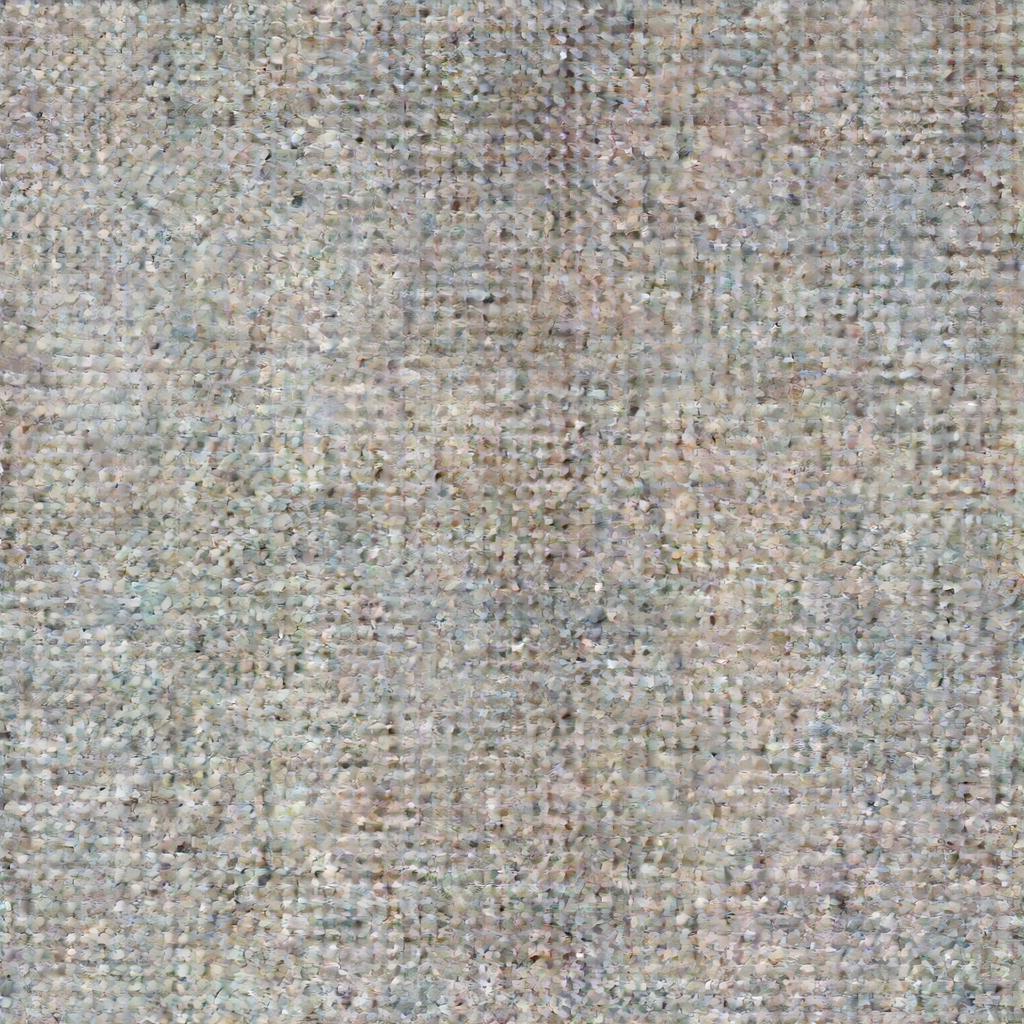

In [8]:
generator = torch.Generator(device="cpu").manual_seed(0)
image = pipe(
    "A cat holding a sign that says hello world",
    negative_prompt="",
    num_inference_steps=28,
    guidance_scale=7.0,
    generator=generator
).images[0]
image

100%|██████████| 28/28 [00:04<00:00,  6.97it/s]


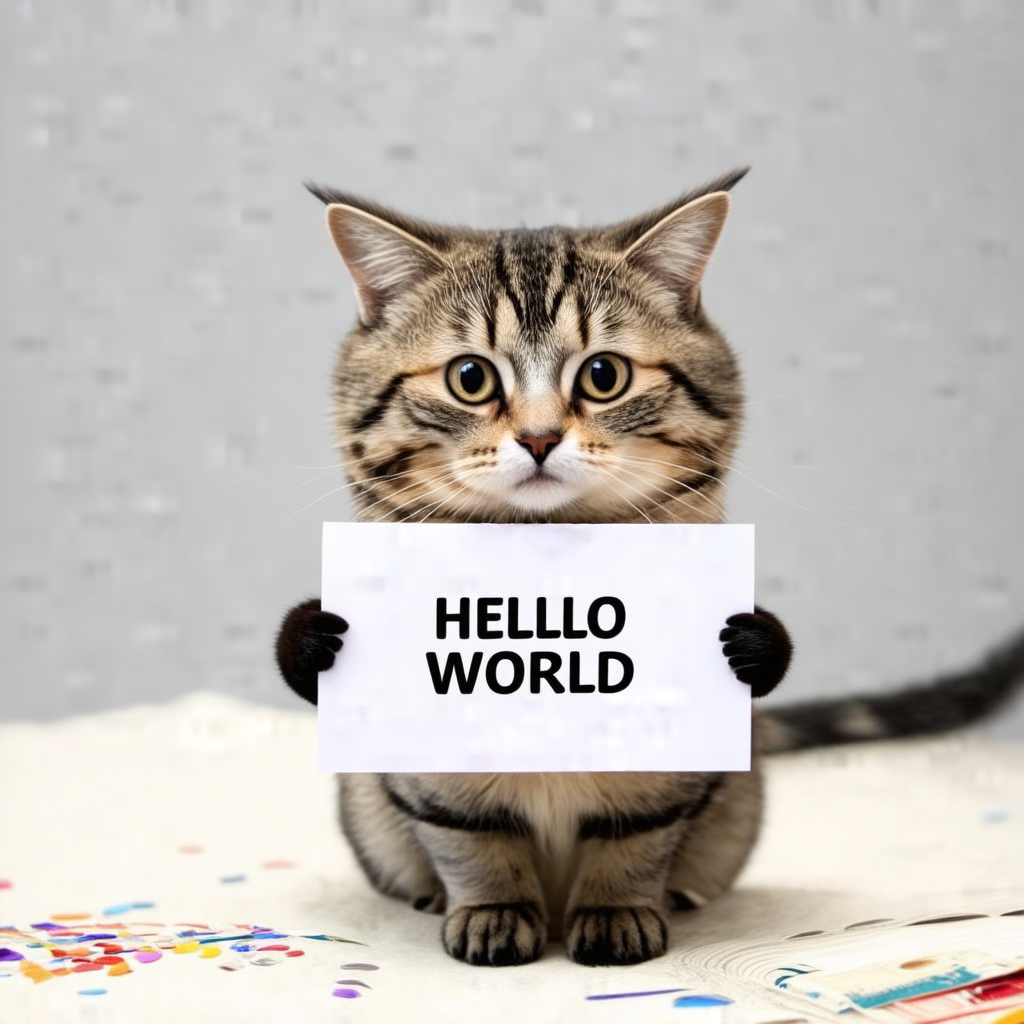

In [42]:
generator = torch.Generator(device="cpu").manual_seed(0)
image = pipe(
    "A cat holding a sign that says hello world",
    negative_prompt="",
    num_inference_steps=28,
    guidance_scale=7.0,
    generator=generator
).images[0]
image

In [6]:
# # Reimport attention
# import Attention as Attention
# import importlib
# importlib.reload(Attention)
# Attention = Attention.Attention

In [7]:
# # Get stable diffusion 3 config
# config = pipe.transformer.config

# # Replace attention in stable diffusion with the imported one
# for layer in pipe.transformer.transformer_blocks:
#     old = layer.attn
#     layer.attn = Attention(
#         query_dim = old.query_dim,
#         cross_attention_dim = old.cross_attention_dim,
#         heads = old.heads,
#         kv_heads = None,
#         dim_head = 64,
#         dropout = old.dropout,
#         bias = old.use_bias,
#         upcast_attention = old.upcast_attention,
#         upcast_softmax = old.upcast_softmax,
#         cross_attention_norm = None,
#         cross_attention_norm_num_groups = 32,
#         qk_norm = None,
#         added_kv_proj_dim = old.added_kv_proj_dim,
#         added_proj_bias = old.added_proj_bias,
#         norm_num_groups = None,
#         spatial_norm_dim = None,
#         out_bias = True,
#         scale_qk = old.scale_qk,
#         only_cross_attention = old.only_cross_attention,
#         eps = 1e-5,
#         rescale_output_factor = old.rescale_output_factor,
#         residual_connection = old.residual_connection,
#         _from_deprecated_attn_block = old._from_deprecated_attn_block,
#         processor = old.processor,
#         out_dim = old.out_dim,
#         context_pre_only = old.context_pre_only,
#         pre_only = old.pre_only,
#         elementwise_affine = True,
#     ).to(old.to_k.weight.device).to(old.to_k.weight.dtype)
#     layer.attn.load_state_dict(old.state_dict())
#     del old

  0%|          | 0/28 [02:07<?, ?it/s]


KeyboardInterrupt: 